<a href="https://colab.research.google.com/github/hiris25/Worm-Connectome-Polarity/blob/main/polarity_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Excitatory & Inhibitory Receptor Analysis
- Do Neurons ever express Excit & Inhib receptors for the same ligand?
- Predict sign of a connection based upon relative expresison of excitatory & inhibitory receptor expression
- Calculate the ratios of excitatory & inhibitory connections per transmitter and total



## Set up libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob as glob
import matplotlib.patches as mpatches
import re as re

%config InlineBackend.figure_format = 'retina'

## Import & prep data

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#import connectome
df_connectome = pd.read_excel('/content/drive/MyDrive/Expression/connectome.xlsx')
df_synlist_ori = pd.read_csv('/content/drive/MyDrive/Expression/wormweb_synapselist.csv')
df_NT = pd.read_csv('/content/drive/MyDrive/Expression/NT_list.csv')

#import list of genes with ligand and pos/neg assigment
df_genes = pd.read_excel('/content/drive/MyDrive/Expression/lgc_ligands.xlsx')
df_genes.set_index('Gene', inplace=True)

#import cengen data, including "fake" receptors which have zero expression but all ligands
path = r'/content/drive/MyDrive/Expression/cengen_raw/thr4' # use your path
all_files = glob.glob(path + "/*.csv") # use your extension

li = []

for filename in all_files:
    df_expression = pd.read_csv(filename, index_col=None, header=0) # for .dat files you must specify separation for example sep='\t'
    li.append(df_expression)

df_expression = pd.concat(li, axis=0, ignore_index=True)

df_expression = df_expression.drop(['Unnamed: 0', 'X', 'threshold'],axis=1)
df_expression = df_expression.rename(columns={"gene_name": "Gene"})
df_expression.set_index('Gene', inplace=True)
#df_expression.head(5)

In [4]:
#merge on Gene
df = pd.concat([df_genes, df_expression], axis=1)

#drop Nan on Gated
df_clean = df[df['Gated'].notna()]

#make neuron class list
df_neurons = df_clean.T
df_neurons = df_neurons.drop(['Gated', 'Inferred?', 'Pos/Neg', 'G protein'], axis=0)

## Get White synapse list in shape 

In [5]:
#sort out coloumns to make pre and post rather than diff for each row

def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)
df_synlist_ori['Nbr']=df_synlist_ori['Nbr'].apply(lambda x: find_number(x))

df_synlist_pre= df_synlist_ori.loc[df_synlist_ori.Type.str.contains('S')]
df_synlist_post = df_synlist_ori.loc[df_synlist_ori.Type.str.contains('R')]
df_synlist_ele = df_synlist_ori.loc[df_synlist_ori.Type.str.contains('EJ')]
df_synlist_nmj = df_synlist_ori.loc[df_synlist_ori.Type.str.contains('NMJ')]

df_synlist_pre = df_synlist_pre.rename(columns={"Neuron 1": "Presynaptic_cell", "Neuron 2": "Postsynaptic_cell", "Nbr": "no_synapses"})
df_synlist_post = df_synlist_post.rename(columns={"Neuron 2": "Presynaptic_cell", "Neuron 1": "Postsynaptic_cell", "Nbr": "no_synapses"})

df_synlist_chemical = df_synlist_pre.append(df_synlist_post, ignore_index=True)

df_synlist_chemical_NT = df_synlist_chemical.merge(df_NT, left_on='Presynaptic_cell', right_on='Neuron')

df_synlist_chemical_NT.head()

#df_synlist_chemical_NT.to_csv('/content/drive/MyDrive/Expression/wormweb_synapselist_prepost.csv')

,Presynaptic_cell,Postsynaptic_cell,Type,no_synapses,Neuron,Neurotransmitter
0,ADEL,ADAL,Sp,1,ADEL,DA
1,ADEL,ADER,Sp,1,ADEL,DA
2,ADEL,AVAL,Sp,2,ADEL,DA
3,ADEL,AVAR,Sp,3,ADEL,DA
4,ADEL,AVEL,Sp,1,ADEL,DA


## Make Binary & Expression based predictions on receptor expression in cells

In [6]:
#your list of ligamds, either from a file, hard coded or takem from the df

#ligands = df_clean.Gated.unique() #can use if you dont have receptors binding multiple ligands, otherwise hard coded below

ligands = ['ACh', 'Glu', 'GABA'] #main 3 only

ligandsdict = {elem : pd.DataFrame() for elem in ligands}

for key in ligandsdict.keys():
    ligandsdict[key] = df_clean[:][df_clean.Gated.str.contains(key)]

df_binary_receptors = pd.DataFrame()
df_expression_ratio_receptors = pd.DataFrame()
df_expression_ratio_receptors_negtopos = pd.DataFrame()
df_expressiondiff_receptors = pd.DataFrame()

for key, df in ligandsdict.items():
  df = df.drop(['Gated', 'Inferred?', 'G protein'], axis=1)
  df = df.groupby('Pos/Neg').sum()
  df = df.T
  df_expressiondiff_receptors[key] = df['P'] - df['N']
  df_expression_ratio_receptors[key] = df['P'] / df['N']
  df_binary_receptors[key] = np.where((df['P']> 0) & (df['N'] > 0), 3,  #if both give a number 3
         np.where((df['P']> 0) & (df['N'] == 0), 2, #where only P give number 2
                  np.where((df['P'] == 0) & (df['N'] > 0), 1, 0))) #where only N give number 1, where none give 0

for key, df in ligandsdict.items():
  df = df.drop(['Gated', 'Inferred?', 'G protein'], axis=1)
  df = df.groupby('Pos/Neg').sum()
  df = df.T
  df_expression_ratio_receptors_negtopos[key] = df['N'] / df['P']
  
df_binary_receptors.index = df_neurons.index
df_expression_ratio_receptors_negtopos.head(5)

#df_expression_ratio_receptors_negtopos.to_csv('/content/drive/MyDrive/Expression/df_expression_ratio_receptors_negtopos.csv')

,ACh,Glu,GABA
ADA,1.20281,inf,NaN
ADE,2.47304,inf,0.0
ADF,inf,inf,NaN
ADL,NaN,NaN,NaN
AFD,0.00000,inf,NaN


In [36]:
for a in df_expressiondiff_receptors:
  df_expressiondiff_receptors[a].mask((df_binary_receptors[a] == 0), 'NaN', inplace=True)

df_expressiondiff_receptors.head(5)

,ACh,Glu,GABA
ADA,-57.4882,-99.9456,NaN
ADE,-411.573,-108.734,161.504
ADF,-534.944,-64.5865,NaN
ADL,NaN,NaN,NaN
AFD,76.4548,-256.75,NaN


# Overlay onto connectome

In [11]:
neuron_classes = df_neurons.index.tolist()
#neuron_classes

In [12]:
df_synlist_ele = df_synlist_ele.rename(columns={"Neuron 1": "Presynaptic_cell", "Neuron 2": "Postsynaptic_cell", "Nbr": "no_synapses"})
df_synlist_ele.head(2)

,Presynaptic_cell,Postsynaptic_cell,Type,no_synapses
0,ADAR,ADAL,EJ,1
1,ADFL,ADAL,EJ,1


In [13]:
#asign neuron classes for gap junctions

df_connectome_gap = df_synlist_ele

df_connectome_gap["Presynaptic_cell_class"] = np.nan
df_connectome_gap["Postsynaptic_cell_class"] = np.nan

for c in neuron_classes:
  df_connectome_gap['Presynaptic_cell_class'].mask((df_connectome_gap.Presynaptic_cell.str.startswith(c)), c, inplace=True)
  
for c in neuron_classes:
  df_connectome_gap['Postsynaptic_cell_class'].mask((df_connectome_gap.Postsynaptic_cell.str.startswith(c)), c, inplace=True)

df_connectome_gap.to_csv('/content/drive/MyDrive/Expression/wormweb_connectome_classes_gap.csv')

#now you must manually fix the classes that are extra in cengen such as VD_DD -> this .csv already exists "wormweb_connectome_classes_gap_correct.csv'"

df_connectome_gap_classes = pd.read_csv('/content/drive/MyDrive/Expression/wormweb_connectome_classes_gap_correct.csv')
df_connectome_gap_classes = df_connectome_gap_classes.drop(['Column1'],axis=1)

#df_connectome_gap_classes.head()

#make classes only, combine synapse no. and drop other coloums

df_connectome_classes_gap_only = df_connectome_gap_classes.drop(['Presynaptic_cell', 'Postsynaptic_cell'],axis=1)
#df_connectome_classes_only = df_connectome_classes_only.groupby(['Presynaptic_cell_class', 'Postsynaptic_cell_class']).sum()

df_connectome_classes_gap_only = df_connectome_classes_gap_only.groupby(['Presynaptic_cell_class', 'Postsynaptic_cell_class']).agg({'no_synapses':'sum', 'Type':'first'}).reset_index()

df_connectome_classes_gap_only.head()

,Presynaptic_cell_class,Postsynaptic_cell_class,no_synapses,Type
0,ADA,ADA,2,EJ
1,ADA,ADF,2,EJ
2,ADA,ASH,2,EJ
3,ADA,AVD,4,EJ
4,ADA,PVQ,2,EJ


In [14]:
df = df_connectome_classes_gap_only

new_pairs = []
for i, j in df.iterrows():
  #print(i, j[1], j[0], 'i j')
  if [j[1], j[0]] in  new_pairs:
    df.drop(index = i, inplace = True)
  else:
    new_pairs.append([j[0], j[1]])

df_connectome_classes_gap_only_cleaned = df
df_connectome_classes_gap_only_cleaned.shape

(250, 4)

In [15]:
#assign neuron classes for both pre and post

df_connectome = df_synlist_chemical_NT

df_connectome["Presynaptic_cell_class"] = np.nan
df_connectome["Postsynaptic_cell_class"] = np.nan

for c in neuron_classes:
  df_connectome['Presynaptic_cell_class'].mask((df_connectome.Presynaptic_cell.str.startswith(c)), c, inplace=True)
  
for c in neuron_classes:
  df_connectome['Postsynaptic_cell_class'].mask((df_connectome.Postsynaptic_cell.str.startswith(c)), c, inplace=True)

#df_connectome.to_csv('/content/drive/MyDrive/Expression/wormweb_connectome_classes.csv')

#now you must manually fix the classes that are extra in cengen such as VD_DD -> this .csv already exists "wormweb_connectome_classes_correct.csv"

df_connectome_classes = pd.read_csv('/content/drive/MyDrive/Expression/wormweb_connectome_classes_correct.csv')
df_connectome_classes = df_connectome_classes.drop(['Column1'],axis=1)
#df_connectome_classes['all_NT'] = df_connectome_classes['NT_1'].astype(str) + ', ' + df_connectome_classes['NT_2'].astype(str)

df_connectome_classes.head()

,Presynaptic_cell,Postsynaptic_cell,Type,no_synapses,Neurotransmitter,Presynaptic_cell_class,Postsynaptic_cell_class
0,ADAL,SMDVR,S,2,Glu,ADA,SMD
1,ADAL,SMDVR,R,2,Glu,ADA,SMD
2,ADAL,RIPL,Sp,1,Glu,ADA,RIP
3,ADAL,RIPL,Rp,1,Glu,ADA,RIP
4,ADAL,RIML,Sp,3,Glu,ADA,RIM


In [16]:
#make classes only, combine synapse no. and drop other coloums

df_connectome_classes_only = df_connectome_classes.drop(['Presynaptic_cell', 'Postsynaptic_cell'],axis=1)
#df_connectome_classes_only = df_connectome_classes_only.groupby(['Presynaptic_cell_class', 'Postsynaptic_cell_class']).sum()

df_connectome_classes_only = df_connectome_classes_only.groupby(['Presynaptic_cell_class', 'Postsynaptic_cell_class']).agg({'no_synapses':'sum', 'Neurotransmitter':'first', 'Type':'first'}).reset_index()

df_connectome_classes_only.head()

,Presynaptic_cell_class,Postsynaptic_cell_class,no_synapses,Neurotransmitter,Type
0,ADA,AIB,10,Glu,Sp
1,ADA,AVA,6,Glu,Sp
2,ADA,AVB,36,Glu,S
3,ADA,AVD,2,Glu,Sp
4,ADA,AVE,4,Glu,Sp


In [17]:
#add postsynaptic cell diff and binary receptor expression coloumns, only for primary NT per cell

df_connectome_classes_only['Postsynaptic_receptor_diff'] = np.nan
df_connectome_classes_only['Postsynaptic_receptor_ratio'] = np.nan

for a in df_connectome_classes_only['Postsynaptic_cell_class']:
  df_connectome_classes_only['Postsynaptic_receptor_diff'].mask((df_connectome_classes_only.Neurotransmitter.str.contains('ACh')) & (df_connectome_classes_only.Postsynaptic_cell_class.str.match(a)), df_expressiondiff_receptors['ACh'].loc[a], inplace=True)
  df_connectome_classes_only['Postsynaptic_receptor_diff'].mask((df_connectome_classes_only.Neurotransmitter.str.contains('Glu')) & (df_connectome_classes_only.Postsynaptic_cell_class.str.match(a)), df_expressiondiff_receptors['Glu'].loc[a], inplace=True)
  df_connectome_classes_only['Postsynaptic_receptor_diff'].mask((df_connectome_classes_only.Neurotransmitter.str.contains('GABA')) & (df_connectome_classes_only.Postsynaptic_cell_class.str.match(a)), df_expressiondiff_receptors['GABA'].loc[a], inplace=True)

for a in df_connectome_classes_only['Postsynaptic_cell_class']:
  df_connectome_classes_only['Postsynaptic_receptor_ratio'].mask((df_connectome_classes_only.Neurotransmitter.str.contains('ACh')) & (df_connectome_classes_only.Postsynaptic_cell_class.str.match(a)), df_expression_ratio_receptors['ACh'].loc[a], inplace=True)
  df_connectome_classes_only['Postsynaptic_receptor_ratio'].mask((df_connectome_classes_only.Neurotransmitter.str.contains('Glu')) & (df_connectome_classes_only.Postsynaptic_cell_class.str.match(a)), df_expression_ratio_receptors['Glu'].loc[a], inplace=True)
  df_connectome_classes_only['Postsynaptic_receptor_ratio'].mask((df_connectome_classes_only.Neurotransmitter.str.contains('GABA')) & (df_connectome_classes_only.Postsynaptic_cell_class.str.match(a)), df_expression_ratio_receptors['GABA'].loc[a], inplace=True)

df_connectome_classes_only['Postsynaptic_receptor_diff'] = df_connectome_classes_only['Postsynaptic_receptor_diff'].apply(pd.to_numeric, errors='coerce')

df_connectome_classes_only['synapse_sign'] = np.where(df_connectome_classes_only['Postsynaptic_receptor_diff'] > 0, 1, np.where(df_connectome_classes_only['Postsynaptic_receptor_diff'] < 0, -1, 0))
df_connectome_classes_only['total_synapses_at_weight'] = df_connectome_classes_only['synapse_sign'] * df_connectome_classes_only['no_synapses']

df_connectome_classes_only.head()


,Presynaptic_cell_class,Postsynaptic_cell_class,no_synapses,Neurotransmitter,Type,Postsynaptic_receptor_diff,Postsynaptic_receptor_ratio,synapse_sign,total_synapses_at_weight
0,ADA,AIB,10,Glu,Sp,180.438784,3.224527,1,10
1,ADA,AVA,6,Glu,Sp,3438.130466,8.965383,1,6
2,ADA,AVB,36,Glu,S,-172.774637,0.331923,-1,-36
3,ADA,AVD,2,Glu,Sp,5038.120674,22.417895,1,2
4,ADA,AVE,4,Glu,Sp,2875.703403,inf,1,4


In [23]:
df_connectome_classes_only_groups = df_connectome_classes_only.groupby(['Neurotransmitter', 'synapse_sign']).sum()
df_connectome_classes_only_groups.head(20)

df_connectome_classes_only_groups.to_csv('/content/drive/MyDrive/Expression/grouped_classes_2jun21.csv')

In [24]:
df_connectome_classes_only_synpases = pd.DataFrame()

df_connectome_classes_only_synpases['total_synapses_at_weight'] = df_connectome_classes_only['total_synapses_at_weight']

neg = df_connectome_classes_only_synpases.where(df_connectome_classes_only_synpases != df_connectome_classes_only_synpases.abs()).sum(0)
pos = df_connectome_classes_only_synpases.where(df_connectome_classes_only_synpases == df_connectome_classes_only_synpases.abs()).sum(0)
ratio = pos/-neg

print('Ratio of Excitetory to Inhibitory Synapses: ', ratio, ":1")

Ratio of Excitetory to Inhibitory Synapses:  total_synapses_at_weight    1.903804
dtype: float64 :1


In [25]:
#add neuron types and any other info needed for network
df_nodes = pd.read_csv('/content/drive/MyDrive/Expression/nodes.csv')
df_nodes = df_nodes.set_index('name')
df_nodes = df_nodes.drop(['selected', 'shared name'],axis=1)

df_network = df_connectome_classes_only.merge(df_nodes, left_on='Presynaptic_cell_class', right_on='name')
df_network.shape

(1062, 13)

In [26]:
df_network_withgap = df_network.append(df_connectome_classes_gap_only_cleaned)

In [27]:
df_network_withgap.to_csv('/content/drive/MyDrive/Expression/wormweb_synapse_network_withgap_clean_2june21.csv')

#import this into cytoscape for further analysis and visualisation

## Plot Heatmaps

In [ ]:
#optional data export to csv
#df_binary_receptors.to_csv('/content/drive/MyDrive/Expression/binaryligands.csv')

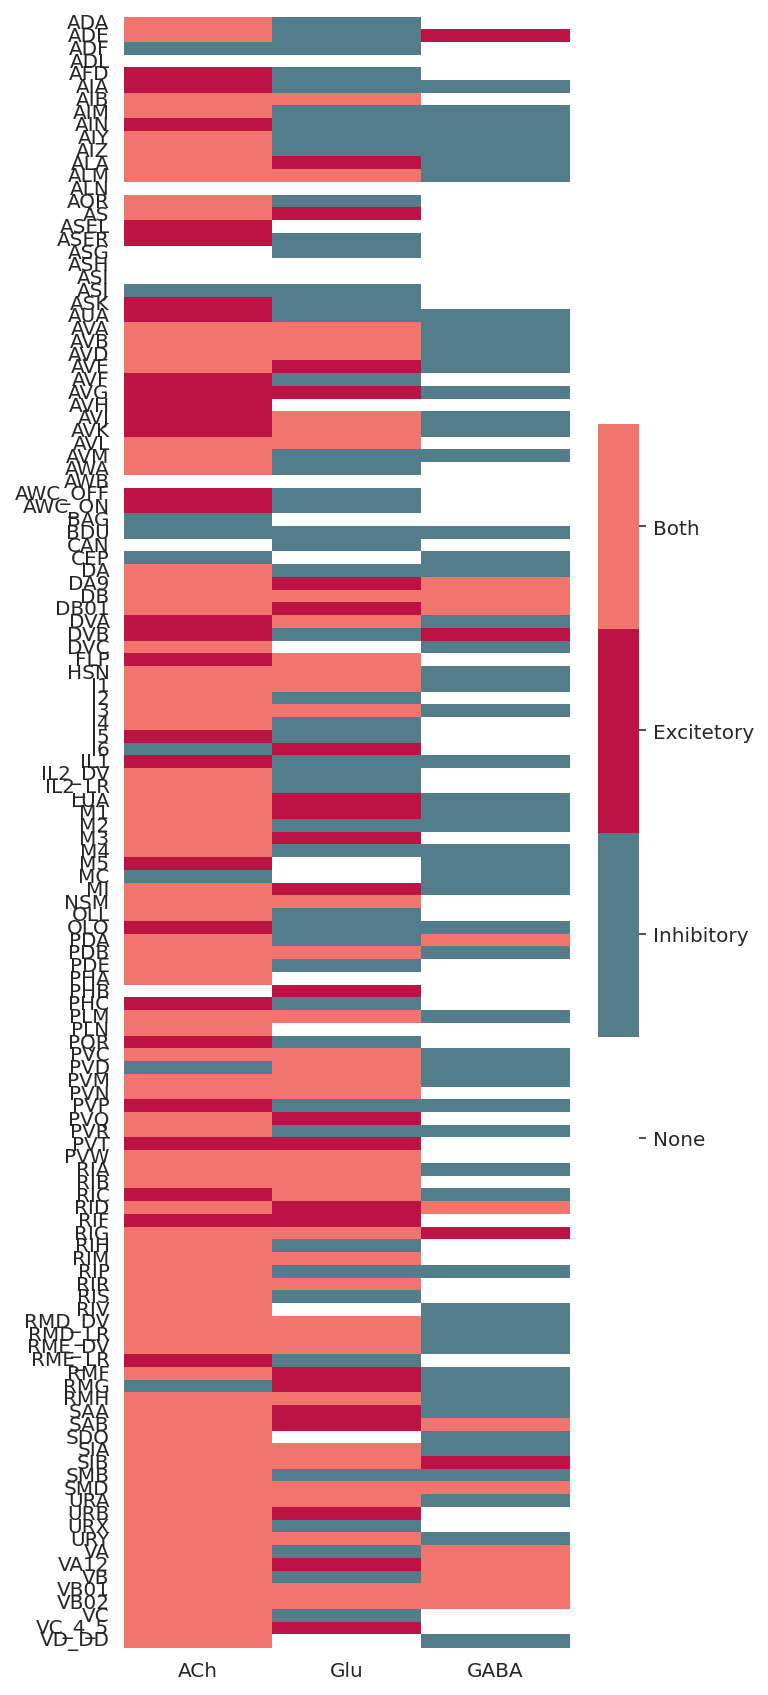

In [31]:
#Binary Heatmap with either or and both
#df_plot = df_binary_receptors.apply(pd.to_numeric, errors='coerce') #incase you dont have numbers?!

sns.set_style("dark")

fig, ax = plt.subplots(figsize=(5,15)) 

my_colors=[('white'),('#537D8A'),('#BD1344'),('#F2756D')]

sns.heatmap(df_binary_receptors, cmap=my_colors, ax=ax, yticklabels=True, cbar_kws={"shrink": 0.5})

colorbar = ax.collections[0].colorbar
M=df_binary_receptors.max().max()
colorbar.set_ticks([1/8*M,3/8*M,5/8*M,7/8*M])
colorbar.set_ticklabels(['None','Inhibitory','Excitetory','Both'])

#plt.show()

plt.savefig('/content/drive/MyDrive/Expression/+ - graphs v1/threshold 4/binary_heatmap_2june21.pdf')

In [33]:
df_expressiondiff_receptors = df_expressiondiff_receptors.replace('NaN', np.nan)

df_expressiondiff_receptors.dtypes

ACh     float64
Glu     float64
GABA    float64
dtype: object

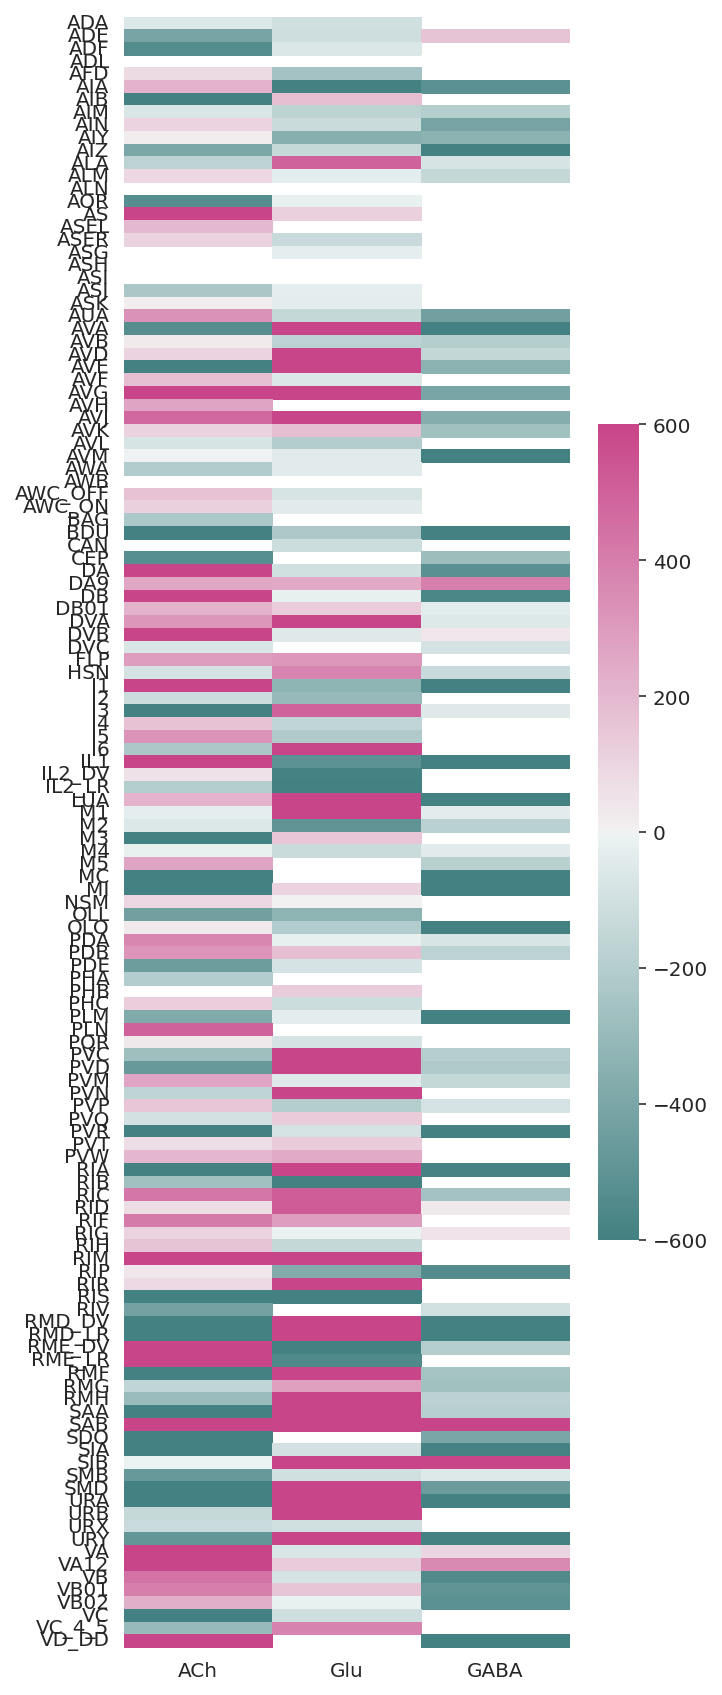

In [34]:
#Expression Level Heatmap
#df_plot = df_expressiondiff_receptors.apply(pd.to_numeric, errors='coerce') #incase you dont have numbers?!
df_plot = df_expressiondiff_receptors

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(5,15)) 

colour = sns.diverging_palette(194, 343, s=70, center="light", as_cmap=True)

#colour = sns.diverging_palette(220, 20, s=100, center="light", as_cmap=True) #red to blue

sns.heatmap(df_plot, cmap=colour, ax=ax, yticklabels=True, center=0.00, vmax=600, vmin=-600, cbar_kws={"shrink": 0.5})

#sns.heatmap(df_plot, cmap='coolwarm', ax=ax, yticklabels=True, center=0.00, cbar_kws={"shrink": 0.5})

#plt.show()

plt.savefig('/content/drive/MyDrive/Expression/+ - graphs v1/threshold 4/expression_heatmap_pink_2june21.pdf')